In [1]:
import os
import sys
code_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code'
code_dir_2 = '/home/ben/ben-rhodes-masters-project/proposal/code'
code_dir_3 = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code/neural_network'
code_dir_4 = '/home/ben/ben-rhodes-masters-project/proposal/code/neural_network'
code_dirs = [code_dir, code_dir_2, code_dir_3, code_dir_4]
for code_dir in code_dirs:
    if code_dir not in sys.path:
        sys.path.append(code_dir)

In [2]:
import numpy as np
import pickle

# my code
from distribution import MissingDataProductOfTruncNormsPosterior, MissingDataProductOfTruncNormNoise
from fully_observed_models import MixtureOfTwoGaussians
from latent_variable_model import MissingDataUnnormalisedTruncNorm
from nce_optimiser import NCEOptimiser
from plot import *
from utils import *
from vnce_optimiser import VemOptimiser, SgdEmStep, MonteCarloVnceLoss

from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import newton_krylov
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=1)
rc('font', size=10)
rc('legend', fontsize=10)

In [3]:
load_path = '/home/ben/ben-rhodes-masters-project/experimental_results/trunc_norm/test/test/'

In [4]:
vnce_model = pickle.load(open(os.path.join(load_path, 'vnce_model.p'), 'rb'))

In [5]:
nce_model = pickle.load(open(os.path.join(load_path, 'nce_model.p'), 'rb'))

In [6]:
var_dist = pickle.load(open(os.path.join(load_path, 'var_dist.p'), 'rb'))

In [7]:
noise = pickle.load(open(os.path.join(load_path, 'noise.p'), 'rb'))

In [8]:
globals().update(np.load(os.path.join(load_path, 'data.npz')))
globals().update(np.load(os.path.join(load_path, 'theta0_and_theta_true.npz')))

In [9]:
# contour plot of q(z|x)p_y(x) next to cplot of model 
# do this for two cases: z is first dimension, and z is second dimension
def get_visible_and_latents(U, latent_dim=1):
    visible_dim = int(~latent_dim)
    x = np.zeros_like(U)
    z = np.zeros((1, ) + U.shape)
    x[:, visible_dim] = U[:, visible_dim]
    z[0, :, latent_dim] = U[:, latent_dim]
    return x, z

def joint_noise(U):
    x, z = get_visible_and_latents(U)
    return var_dist(z, x) * noise(x)

def joint_noise_rev(U):
    x, z = get_visible_and_latents(U, latent_dim=0)
    return var_dist(z, x) * noise(x)

def eval_vnce_model(U):
    x, z = get_visible_and_latents(U)
    return vnce_model(x, z)

def eval_nce_model(U):
    return nce_model(U)

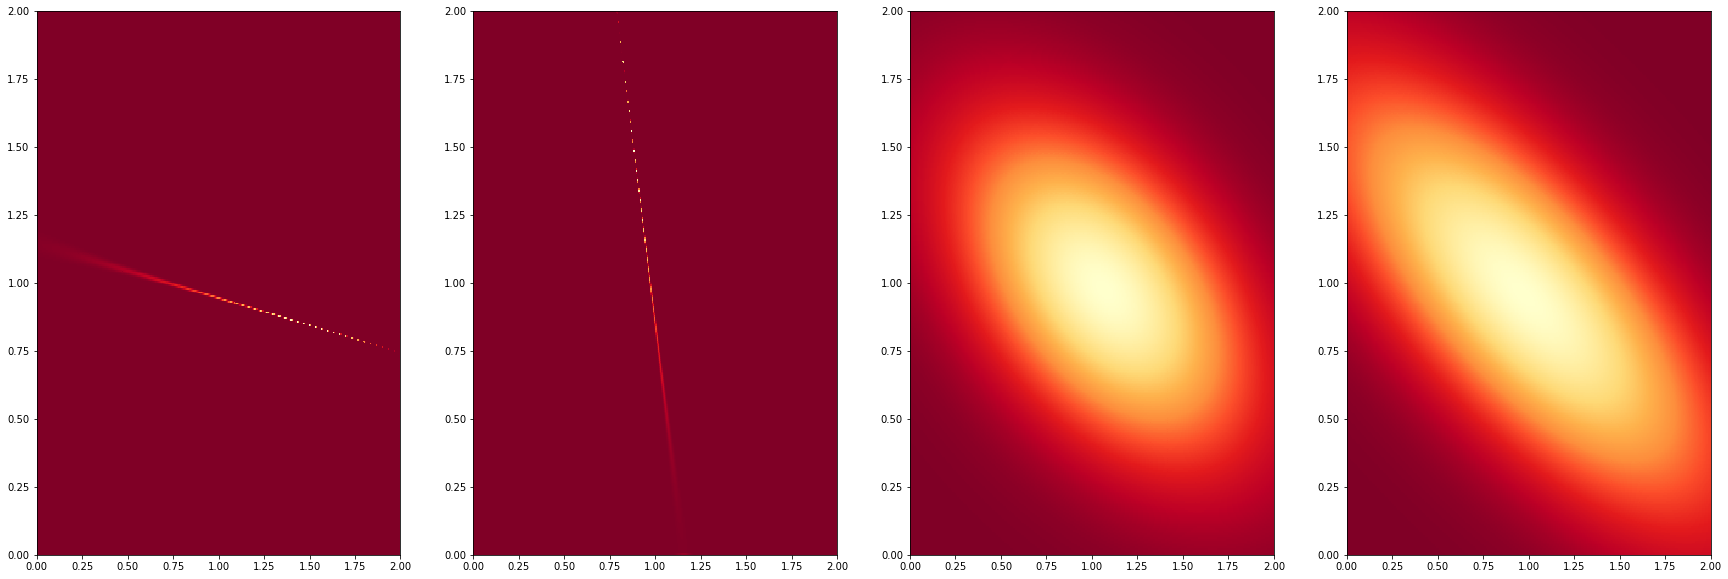

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(30, 10))
axs = axs.ravel()
plot_2d_density(axs[0], joint_noise, plt.cm.YlOrRd_r, low_x_lim=0, up_x_lim=2, low_y_lim=0, up_y_lime=2)
plot_2d_density(axs[1], joint_noise_rev, plt.cm.YlOrRd_r,  low_x_lim=0, up_x_lim=2, low_y_lim=0, up_y_lime=2)
plot_2d_density(axs[2], eval_vnce_model, plt.cm.YlOrRd_r,  low_x_lim=0, up_x_lim=2, low_y_lim=0, up_y_lime=2)
plot_2d_density(axs[3], eval_nce_model, plt.cm.YlOrRd_r,  low_x_lim=0, up_x_lim=2, low_y_lim=0, up_y_lime=2)

In [11]:
noise.alpha

array([ 0.98986556,  0.9479654 ,  0.39740212,  0.76872111])

In [12]:
var_dist.nn.params

[array([[ -1.21856381e-04,  -1.83682410e-01],
        [ -1.99973332e-01,   9.59824913e-04],
        [  8.94201068e-04,   2.56370251e+00],
        [  2.52493016e+00,   6.66893817e-04]]),
 array([ 1.15574478,  1.14291902,  3.72402704,  3.54622987])]

In [13]:
vnce_model.theta

array([-0.5086419 ,  1.06692029,  0.97378913,  0.76252116,  1.33521448,
        0.90328596])

In [14]:
nce_model.theta

array([-0.12373762,  0.97005044,  0.95629689,  0.70435674,  1.984246  ,
        0.65470436])

In [15]:
# old -  0.76872111
# noise.alpha[-2] = 0.7687211